## Preprocessing


First, The required libraries are imported.

In [ ]:
!pip install hazm

In [ ]:
import json


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils.vis_utils import plot_model
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import re
from hazm import *
from tqdm import tqdm  
import codecs
import nltk
from nltk.tokenize import word_tokenize
from __future__ import unicode_literals
from hazm import Normalizer





%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Loading the annotated news

In [ ]:
with open("/content/dataset_annotated_sentiment.json") as f:
  data = json.load(f)

Dividing the dataset into train, validation, and test set.

In [ ]:
train_raw_text, train_raw_labels = [data['train'][i]['text'] for i in range(len(data['train']))], [data['train'][i]['annotations'] for i in range(len(data['train']))]
eval_raw_text, eval_raw_labels = [data['eval'][i]['text'] for i in range(len(data['eval']))], [data['eval'][i]['annotations'] for i in range(len(data['eval']))]
test_raw_text, test_raw_labels = [data['test'][i]['text'] for i in range(len(data['test']))],  [data['test'][i]['annotations'] for i in range(len(data['test']))]


train_df = pd.DataFrame({"raw": train_raw_text, "raw_label": train_raw_labels})
eval_df = pd.DataFrame({"raw": eval_raw_text, "raw_label": eval_raw_labels})
test_df = pd.DataFrame({"raw": test_raw_text, "raw_label": test_raw_labels})

In [ ]:
train_df

,raw,raw_label
0,آتش سوزی کارخانه جمیل نخ گسترده است / اعزام نی...,"[منفی, منفی, منفی]"
1,تجهیزات باکیفیت صنعتی آشپزخانه و کافی شاپ\n___...,"[مثبت, مثبت, خنثی]"
2,برگزاری جشنواره رسانه ابوذر در دی ماه سال جاری...,"[مثبت, خنثی, خنثی]"
3,افزایش 80 درصدی فروش سلاح در آمریکا در ژانویه ...,"[منفی, منفی, منفی]"
4,بازداشت دو تروریست که در بمب گذاری مسیر زائران...,"[خنثی, مثبت]"
...,...,...
1445,پیش بینی پیر جماران!(یادداشت روز)\n___________...,"[خنثی, مثبت, خنثی]"
1446,افتتاح یک باب مدرسه خیرساز در فاریاب\n________...,"[مثبت, مثبت, مثبت]"
1447,چرا وزارت نفت درباره مطالبه راه اندازی دفتر نف...,[منفی]
1448,اطلاع رسانی عجیب پرسپولیس از تمرین امروز\n____...,"[خنثی, خنثی, خنثی]"


Each passage is labeled by varying number of annotators so we assigned each passage the most frequent label. Some of the passages have more than one frequent label we ignore those passages.

In [ ]:
def re_annotation_data(data_text, data_labels, group):
  reannotation_list = []
  for i in range(len(data_labels)):
    if (len(data_labels[i]) == 2 and data_labels[i][0] != data_labels[i][1]) or len(data_labels[i]) == 0:
      reannotation_list.append((data_text[i], group, i))
  return reannotation_list

def create_csv(reanno_list, name):
  reanno_text, reanno_group, reanno_ind = [sample[0] for sample in reannotation_list], [sample[1] for sample in reannotation_list], [sample[2] for sample in reannotation_list]
  reannotation_df = pd.DataFrame({"my_text": reanno_text, "group": reanno_group, "index": reanno_ind})
  reannotation_df.to_csv(name + ".csv")



reannotation_list = re_annotation_data(train_raw_text, train_raw_labels, "train") + re_annotation_data(eval_raw_text, eval_raw_labels, "eval") + re_annotation_data(test_raw_text, test_raw_labels, "test") 

first_reannotation_list = reannotation_list[:int(len(reannotation_list)/2)]
second_reannotation_list = reannotation_list[int(len(reannotation_list)/2):]


In [ ]:
class_names = ['منفی','خنثی','مثبت']
def unknown_labels(label_list):
    if (len(label_list) == 2 and label_list[0] != label_list[1]) or (len(label_list) == 0):
      return 0 # label can not be known as the two annotations are different
    else:
      return 1 # label can be understood as you can assign the class with majority labels to the class
    
def most_frequent(labels):
    labels = list(labels)
    return (max(set(labels), key = labels.count))

def to_sentiment(rating):
  if rating == 'منفی':
    return 0
  elif rating == 'خنثی' :
    return 1
  else: 
    return 2

train_df["is_unknown"] = train_df["raw_label"].apply(unknown_labels)
train_df = train_df[train_df["is_unknown"] == 1]
train_df['label'] = train_df["raw_label"].apply(most_frequent)
train_df = train_df.drop(columns = ['is_unknown'])
train_df['label'] = train_df["label"].apply(to_sentiment)

eval_df["is_unknown"] = eval_df["raw_label"].apply(unknown_labels)
eval_df = eval_df[eval_df["is_unknown"] == 1]
eval_df['label'] = eval_df["raw_label"].apply(most_frequent)
eval_df = eval_df.drop(columns = ['is_unknown'])
eval_df['label'] = eval_df["label"].apply(to_sentiment)

test_df["is_unknown"] = test_df["raw_label"].apply(unknown_labels)
test_df = test_df[test_df["is_unknown"] == 1]
test_df['label'] = test_df["raw_label"].apply(most_frequent)
test_df = test_df.drop(columns = ['is_unknown'])
test_df['label'] = test_df["label"].apply(to_sentiment)

### Data Cleaning
removing the backslash signs in the news and unnecessary new line characters.

In [ ]:
import re
train_df["text"] = train_df["raw"].apply(lambda x: re.sub(r"\s_+\s", ". ", x))
train_df["text"] = train_df["text"].apply(lambda x: x.replace('/ ', ""))
train_df['len'] = train_df['text'].apply(lambda x: len(x))

eval_df["text"] = eval_df["raw"].apply(lambda x: re.sub(r"\s_+\s", ". ", x))
eval_df["text"] = eval_df["text"].apply(lambda x: x.replace('/ ', ""))
eval_df['len'] = eval_df['text'].apply(lambda x: len(x))

test_df["text"] = test_df["raw"].apply(lambda x: re.sub(r"\s_+\s", ". ", x))
test_df["text"] = test_df["text"].apply(lambda x: x.replace('/ ', ""))
test_df['len'] = test_df['text'].apply(lambda x: len(x))

Normalizing the data using Hazm Library. We also removed stop words as we believe the stopwords don't convey any sentimental values.

In [ ]:
normalizer = Normalizer()
train_df['normalized'] = train_df['text'].apply(lambda x: normalizer.normalize(x))
eval_df['normalized'] = eval_df['text'].apply(lambda x: normalizer.normalize(x))
test_df['normalized'] = test_df['text'].apply(lambda x: normalizer.normalize(x))

In [ ]:
!wget -cO "stopwords.txt" "https://raw.githubusercontent.com/kharazi/persian-stopwords/master/nonverbal" 

--2022-07-29 11:43:41--  https://raw.githubusercontent.com/kharazi/persian-stopwords/master/nonverbal
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1331 (1.3K) [text/plain]
Saving to: ‘stopwords.txt’

stopwords.txt       100%[===================>]   1.30K  --.-KB/s    in 0s      

2022-07-29 11:43:41 (61.0 MB/s) - ‘stopwords.txt’ saved [1331/1331]



In [ ]:
from hazm import word_tokenize
f = open("/content/stopwords.txt", "r")
stop_words = f.read().splitlines()
embedding = {}

train_df["tokens"] = train_df["normalized"].apply(lambda x:word_tokenize(x))
train_df["tokens"] = train_df["tokens"].apply(lambda tokens:[token for token in tokens if not(token in stop_words)])
train_df["preprocessed"] = train_df["tokens"].apply(lambda tokens: " ".join(tokens))
train_df["seq len"] = train_df["tokens"].apply(lambda tokens: len(tokens))

eval_df["tokens"] = eval_df["normalized"].apply(lambda x: word_tokenize(x))
eval_df["tokens"] = eval_df["tokens"].apply(lambda tokens:[token for token in tokens if not(token in stop_words)])
eval_df["preprocessed"] = eval_df["tokens"].apply(lambda tokens: " ".join(tokens))

test_df["tokens"] = test_df["normalized"].apply(lambda x: word_tokenize(x))
test_df["tokens"] = test_df["tokens"].apply(lambda tokens:[token for token in tokens if not(token in stop_words)])
test_df["preprocessed"] = test_df["tokens"].apply(lambda tokens: " ".join(tokens))




/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


max seq len:  121


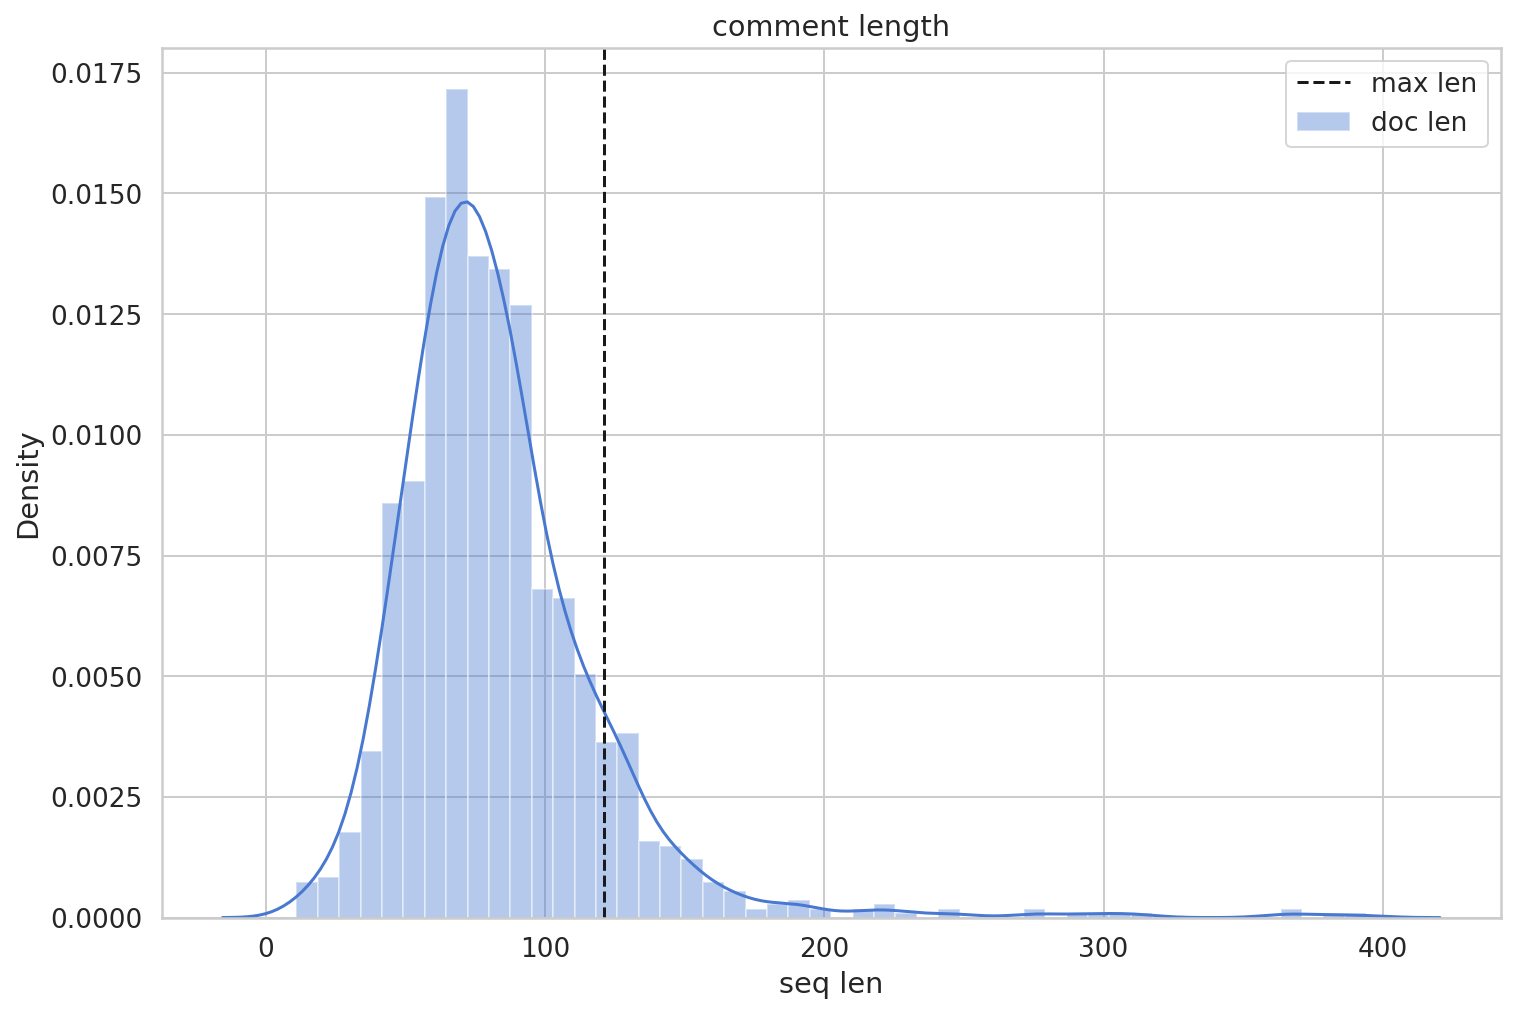

In [ ]:
sns.distplot(train_df['seq len'], hist=True, kde=True, color='b', label='doc len')
max_seq_len = np.round(train_df['seq len'].mean() + train_df['seq len'].std()).astype(int)
print("max seq len: ", max_seq_len)
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [ ]:
tokenizer = Tokenizer(nb_words=20000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=' ')
tokenizer.fit_on_texts(train_df['normalized'].values)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


## Training Vanilla LSTM model

After converting the sentences into sequences we added each padding to them so that every sequence has a padding of 300.

In [ ]:
X_train = tokenizer.texts_to_sequences(train_df['normalized'].values)
X_train = pad_sequences(X_train, maxlen= 300)

X_eval = tokenizer.texts_to_sequences(eval_df['normalized'].values)
X_eval = pad_sequences(X_eval, maxlen = 300)

X_test = tokenizer.texts_to_sequences(test_df['normalized'].values)
X_test = pad_sequences(X_test, maxlen=300)

### Model definition

In [ ]:
embed_dim = 128
lstm_out = 196
batch_size = 32

model = Sequential()
model.add(Embedding(20000, embed_dim,input_length = X_train.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 300, 128)          2560000   
                                                                 
 dropout_7 (Dropout)         (None, 300, 128)          0         
                                                                 
 lstm_6 (LSTM)               (None, 196)               254800    
                                                                 
 dropout_8 (Dropout)         (None, 196)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                 591       
                                                                 
Total params: 2,815,391
Trainable params: 2,815,391
Non-trainable params: 0
_________________________________________________________________
None


One hot encoding of labels

In [ ]:
Y_train = pd.get_dummies(train_df['label']).values
Y_eval = pd.get_dummies(eval_df['label']).values
Y_test = pd.get_dummies(test_df['label']).values

In [ ]:
model.fit(X_train, Y_train, batch_size =batch_size, epochs = 30,  verbose = 2, validation_data = (X_eval, Y_eval))

Epoch 1/30
44/44 - 4s - loss: 1.0390 - accuracy: 0.5057 - val_loss: 1.0518 - val_accuracy: 0.4444 - 4s/epoch - 89ms/step
Epoch 2/30
44/44 - 1s - loss: 0.9892 - accuracy: 0.5250 - val_loss: 1.0168 - val_accuracy: 0.4861 - 884ms/epoch - 20ms/step
Epoch 3/30
44/44 - 1s - loss: 0.6902 - accuracy: 0.7471 - val_loss: 0.8806 - val_accuracy: 0.6111 - 872ms/epoch - 20ms/step
Epoch 4/30
44/44 - 1s - loss: 0.3097 - accuracy: 0.9043 - val_loss: 1.0167 - val_accuracy: 0.5417 - 860ms/epoch - 20ms/step
Epoch 5/30
44/44 - 1s - loss: 0.0946 - accuracy: 0.9736 - val_loss: 1.3330 - val_accuracy: 0.5417 - 873ms/epoch - 20ms/step
Epoch 6/30
44/44 - 1s - loss: 0.0345 - accuracy: 0.9921 - val_loss: 1.5704 - val_accuracy: 0.5139 - 882ms/epoch - 20ms/step
Epoch 7/30
44/44 - 1s - loss: 0.0365 - accuracy: 0.9921 - val_loss: 1.2550 - val_accuracy: 0.5278 - 869ms/epoch - 20ms/step
Epoch 8/30
44/44 - 1s - loss: 0.0255 - accuracy: 0.9950 - val_loss: 1.5147 - val_accuracy: 0.5139 - 887ms/epoch - 20ms/step
Epoch 9/30


The vanilla LSTM model does not achieve the Desired Accuracy on validation set so we try using fast-text encoding instead of one-hot encoding for our model.

## LSTM with Fasttext as its input Embedding

Downloading Fastext library and Weights

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!pip install .
%cd ..

In [ ]:
import fasttext
import fasttext.util

in case you haven't downloaded fasttext please download and save it on your drive:

In [ ]:
fasttext.util.download_model('fa', if_exists='ignore')

'cc.fa.300.bin'

In [ ]:
!cp "/content/cc.fa.300.bin" "/content/drive/MyDrive/Arshad/NLP/Fasttext persian"

cp: cannot create regular file '/content/drive/MyDrive/Arshad/NLP/Fasttext persian': No such file or directory


in case you have downloaded the fasttext weights before please load it:

In [ ]:
!cp "/content/drive/MyDrive/Arshad/NLP/Fasttext persian/cc.fa.300.bin" "/content/" 

cp: cannot stat '/content/drive/MyDrive/Arshad/NLP/Fasttext persian/cc.fa.300.bin': No such file or directory


In [ ]:
ft = fasttext.load_model('cc.fa.300.bin')

Using Fasttext 

In [ ]:
tokenizer = Tokenizer(nb_words=20000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=' ')
tokenizer.fit_on_texts(train_df['preprocessed'].tolist() + eval_df['preprocessed'].tolist() + test_df['preprocessed'].tolist())
word_seq_train = tokenizer.texts_to_sequences(train_df['preprocessed'].values )
word_seq_eval = tokenizer.texts_to_sequences(eval_df['preprocessed'].values)
word_seq_test = tokenizer.texts_to_sequences(test_df['preprocessed'].values)
word_index = tokenizer.word_index

word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_eval = sequence.pad_sequences(word_seq_eval, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [ ]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

We derived An embedding matrix from fasttext and used it as weights for our embedding layer.

In [ ]:
#embedding matrix
MAX_NB_WORDS = 20000
print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = ft[word]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 28


### model definition

In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf

def create_model(dropout_rate=0.4, lstm_units=32):
  model = tf.keras.Sequential()
  model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
  model.add(Bidirectional(LSTM(lstm_units)))
  model.add(Dense(32,activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(3,activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

Finding the best parameters for our model: Dropout rate, number of lstm units and number of epochs

In [ ]:

model = KerasClassifier(build_fn=create_model, epochs=40, verbose=0)
csv_logger = CSVLogger('training.log')
filepath = "weights-improvement-{dropout_rate:02d}-{lstm_units}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='max')
call_back = [csv_logger, checkpoint]
lstm_units = [32, 48, 64]
epochs = [20, 30, 40]
dropout_rate = [0.3, 0.4, 0.5]
param_grid = dict(dropout_rate=dropout_rate, lstm_units=lstm_units, epochs = epochs)
my_test_fold = []
for i in range(len(X_train)):
    my_test_fold.append(-1)

for i in range(len(X_eval)):
    my_test_fold.append(0)
ps = PredefinedSplit(my_test_fold)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=ps)
grid_result = grid.fit(np.concatenate((word_seq_train, word_seq_eval), axis=0) , np.concatenate((Y_train, Y_eval), axis=0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
grid_result.best_params_['epochs']

30

In [ ]:
grid_result.best_score_

0.625

Training the model with train and validation set and getting the final accuracy and performance!

In [ ]:
model = create_model(grid_result.best_params_['dropout_rate'], grid_result.best_params_['lstm_units'])
model.fit(np.concatenate((word_seq_train, word_seq_eval), axis=0) ,np.concatenate((Y_train, Y_eval), axis=0), batch_size =batch_size,epochs = grid_result.best_params_['epochs'],  verbose = 2, validation_data = (word_seq_test, Y_test))
                                                                   

Epoch 1/30
6/6 - 6s - loss: 1.0947 - accuracy: 0.3730 - val_loss: 1.0730 - val_accuracy: 0.4583 - 6s/epoch - 948ms/step
Epoch 2/30
6/6 - 0s - loss: 1.0645 - accuracy: 0.4959 - val_loss: 1.0455 - val_accuracy: 0.4583 - 157ms/epoch - 26ms/step
Epoch 3/30
6/6 - 0s - loss: 1.0415 - accuracy: 0.5020 - val_loss: 1.0302 - val_accuracy: 0.4583 - 129ms/epoch - 22ms/step
Epoch 4/30
6/6 - 0s - loss: 1.0288 - accuracy: 0.5020 - val_loss: 1.0288 - val_accuracy: 0.4583 - 117ms/epoch - 19ms/step
Epoch 5/30
6/6 - 0s - loss: 1.0218 - accuracy: 0.5020 - val_loss: 1.0232 - val_accuracy: 0.4583 - 117ms/epoch - 20ms/step
Epoch 6/30
6/6 - 0s - loss: 1.0169 - accuracy: 0.5020 - val_loss: 1.0169 - val_accuracy: 0.4583 - 110ms/epoch - 18ms/step
Epoch 7/30
6/6 - 0s - loss: 1.0036 - accuracy: 0.5027 - val_loss: 1.0010 - val_accuracy: 0.4583 - 118ms/epoch - 20ms/step
Epoch 8/30
6/6 - 0s - loss: 0.9805 - accuracy: 0.5061 - val_loss: 0.9709 - val_accuracy: 0.4583 - 118ms/epoch - 20ms/step
Epoch 9/30
6/6 - 0s - loss

In [ ]:
y_probs = model.predict(word_seq_test)
y_pred = np.argmax(y_probs,axis=1)
y_test = np.argmax(Y_test, axis=1)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        منفی       0.53      0.64      0.58        14
        خنثی       0.67      0.67      0.67        33
        مثبت       0.59      0.52      0.55        25

    accuracy                           0.61        72
   macro avg       0.60      0.61      0.60        72
weighted avg       0.61      0.61      0.61        72



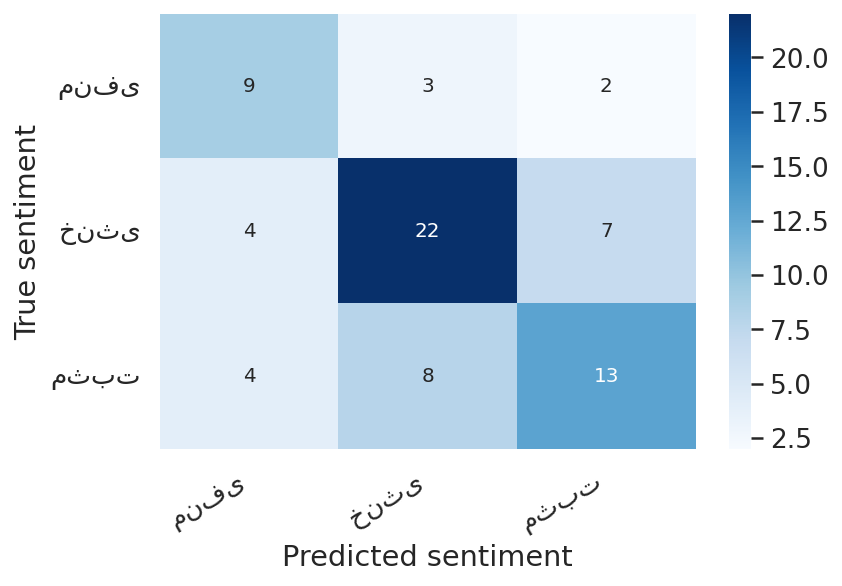

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
class_names = ['منفی','خنثی','مثبت']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
print(test_df['raw'].values[0])
print(model.predict)

رکوردشکنی رمزارز دوم
____________
جریان مداوم اخبار درباره پذیرش ارزهای دیجیتال توسط بانک ها، رشد توکن های غیرقابل تعویض NFT در پلت فرم های بازی مجازی، راه اندازی صندوق های قابل معامله ETF ایالات متحده مبتنی بر معاملات آتی بیت کوین و نیاز سرمایه گذاران به تنوع در یک محیط با نرخ بهره نامشخص، رمزارزها را از اواخر ماه سپتامبر تحت فشار صعودی قرار داده است. رایان راباگلیا، مدیرعامل و رئیس تجارت جهانی در پلت فرم دارایی دیجیتال OSL نیز گفت: «از زمان برگشت بازار در پایان سپتامبر، اتریوم و بیت کوین و سایر ارزهای بزرگ با قدرت در حال حرکت هستند
<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x7fdb351893d0>>


تداوم بی رونقی بازارهای داخلی ____________ همراه با کاهش نرخ بازده
اوراق قرضه ایالات متحده آمریکا، طلا توانست بار دیگر صعودی شده و در روز
جمعه حتی تا نزدیکی 1780 دلار نیز صعود کرده و در نهایت، بهای هر اونس
طلا در آخرین روز معاملاتی بازار جهانی۱0 دلار و 1۰ سنت معادل 6/ 0 درصد
افزایش یافت و در ۱۷76 دلار و 9۰ سنت بسته شد که بالاترین قیمت از ۲۴
فوریه بود. پس از اینکه قیمت طلا سطح مقاومتی مهم ۱۷۶۵ دلار را شکست و در
بالاترین حد دو ماه گذشته قرار گرفت، تحلیلگران به روند افزایشی طلا در
معاملات هفته جاری بی نهایت خوش بین شدند و بر این باورند که طلا می
تواند سطح روانی 1800 دلار را به دست آورده و صعود های بیشتری از خود
نشان دهد

True sentiment: منفی


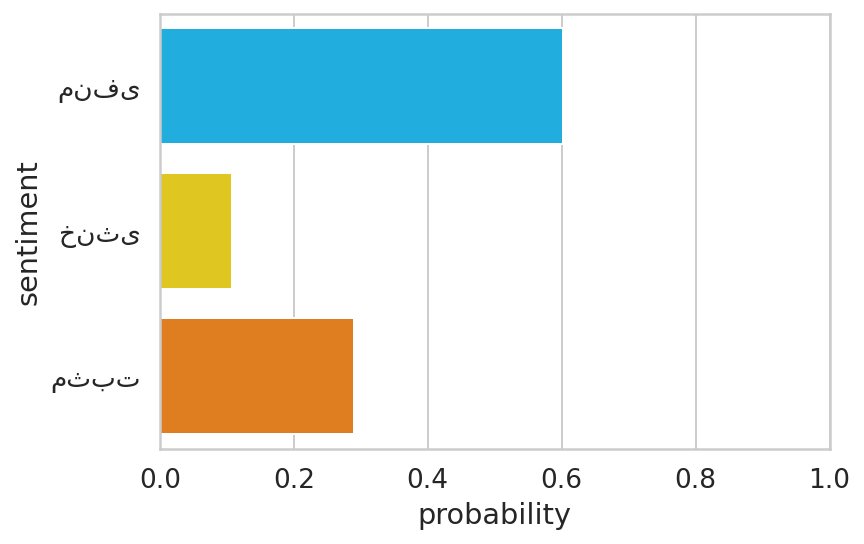

In [ ]:
idx = 20
y_review_texts = test_df['raw'].values
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_probs[idx]
})


print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')


sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

راهنمای دانلود انواع ریمیکس و آهنگ های مختلف ____________ بسیاری از
کاربران نمی توانند به راحتی آهنگ و یا ریمیکس آهنگ مورد نظر خود را در
اینترنت بیابند و یا راه های دستیابی به آن را بلد نیستند و یا در دانلود
نمودن آنها به مشکل برمی خورند. روش های دانلود کردن آهنگ و ریمیکس آهنگ
با گوشی موبایل آیفون

True sentiment: خنثی


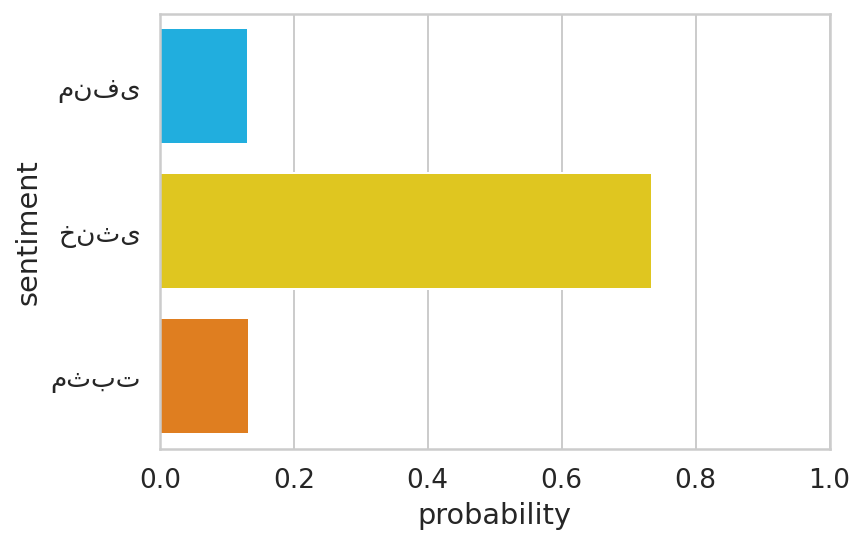

In [ ]:
idx = 21
y_review_texts = test_df['raw'].values
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_probs[idx]
})


print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')


sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

٢٠ زندانی در شب شهادت امام موسی بن جعفر (ع) آزاد می شوند ____________
به گزارش خبرنگار خبرگزاری شبستان از گرگان، «ابوالفضل بخشیانی» امروز
چهارشنبه ۴ اسفند در جمع خبرنگاران گفت: امسال هیئت مهدویون شهرستان
گرگان در قالب مرکز نیکوکاری و موکب با همکاری دستگاه های اجرایی،
استانداری و فرمانداری ها و همه بانیان دست به دست هم داد تا برای اولین
بار یک موکب همزمان با سالروز شهادت امام موسی بن جعفر ع در کاظمین ٧٩
دیگ اطعام کاظمی را آنجا برپا کند. وی اظهارداشت: مراسم آزادی ٢٠ زندانی
همزمان با شب شهادت موسی جعفر ع همراه با پرچم حرم حضرت معصومه س در روز
شنبه ٧ اسفند در امامزاده عبدالله ع گرگان برگزار می شود

True sentiment: مثبت


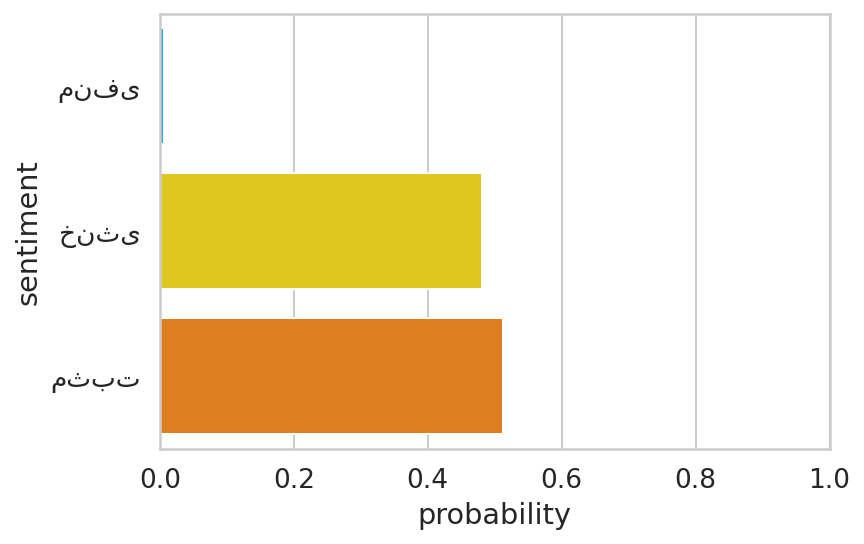

In [ ]:
idx = 29
y_review_texts = test_df['raw'].values
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_probs[idx]
})


print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')


sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);